# Faster FinBERT for Financial Sentiment Analysis

In this notebook, we demonstrate a practical application of knowledge distillation and model compression to speed up model inference.
In this example, we will create a smaller, faster version of FinBERT, a model that has been specialized for financial sentiment analysis.

If you want to review the theory behind the content of this notebook, please refer to Chapters 9 and 10 of the book.




## Install packages

In [1]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.

In [2]:
import pandas as pd
from datasets import load_dataset
import torch
from transformers import AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import time
import pprint

In [3]:
device = (
    torch.device('cuda:0')
    if torch.cuda.is_available() else
    torch.device('cpu')
)

## Setup

Our teacher model will be [FinBERT](https://huggingface.co/ProsusAI/finbert), published by ProsusAI, a model trained to predict the sentiment of financial news. FinBERT is based on the original BERT architecture and has around 109 million parameters.


Our student model will be based on [distilBERT](https://huggingface.co/distilbert/distilbert-base-uncased), which has about 66 million parameters. This is a smaller version of BERT, trained using knowledge distillation from the original BERT model.



In [4]:
TEACHER_MODEL_NAME = "ProsusAI/finbert"
STUDENT_MODEL_NAME = "distilbert/distilbert-base-uncased"

## Data

We will use the [Financial PhraseBank dataset](https://arxiv.org/abs/1307.5336), introduced in the paper by Malo et al. (2014), which is one of the datasets used to develop FinBERT. The dataset consists of 4,846 sentences from English-language financial news, categorized into three sentiment classes: negative, neutral, and positive. The data was annotated by 16 individuals with backgrounds in finance and business.

To make access easier and ensure long-term reproducibility, a copy of the dataset processed has been published in the Hugging Face repo associated with this book. We'll load it directly from there.

In [5]:
DATA_NAME = "gatam4t/genai4t_financial_phrase_bank"

In [6]:
dataset = load_dataset(DATA_NAME)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/549 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/297k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/83.3k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3488 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/388 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/970 [00:00<?, ? examples/s]

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'class', 'label'],
        num_rows: 3488
    })
    validation: Dataset({
        features: ['text', 'class', 'label'],
        num_rows: 388
    })
    test: Dataset({
        features: ['text', 'class', 'label'],
        num_rows: 970
    })
})

In [8]:
dataset['train'][0]

{'text': 'After the reporting period , BioTie North American licensing partner Somaxon Pharmaceuticals announced positive results with nalmefene in a pilot Phase 2 clinical trial for smoking cessation ',
 'class': 'positive',
 'label': 0}

### Preprocessing and Tokenizing the Dataset

Next, we will tokenize the entire dataset using the `.map` method. This will add the `input_ids` and `attention_mask` fields, which are required for model input.  
Moreover, we will remove the `text` and `class` fields from the dataset, as they are no longer needed.


*Note: This implementation assumes that both models use the same tokenizer, which, in this case, they do.*

In [9]:
tokenizer = AutoTokenizer.from_pretrained(STUDENT_MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [10]:
def tokenize_text(batch):
    return tokenizer(batch['text'], truncation=True)

tokenized_dataset = dataset.map(tokenize_text, batched=True, remove_columns=['text', 'class'])

Map:   0%|          | 0/3488 [00:00<?, ? examples/s]

Map:   0%|          | 0/388 [00:00<?, ? examples/s]

Map:   0%|          | 0/970 [00:00<?, ? examples/s]

In [11]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 3488
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 388
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 970
    })
})

In [12]:
item = tokenized_dataset['train'][0]
print("label", item['label'])
print("input_ids", item['input_ids'])
print("attention_mask", item['attention_mask'])

label 0
input_ids [101, 2044, 1996, 7316, 2558, 1010, 16012, 9515, 2167, 2137, 13202, 4256, 2061, 17848, 2239, 24797, 2623, 3893, 3463, 2007, 6583, 13728, 27235, 2638, 1999, 1037, 4405, 4403, 1016, 6612, 3979, 2005, 9422, 8292, 11488, 3508, 102]
attention_mask [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## Model Distillation

Next, we will develop and `DistillationTrainer` and `DistillationTrainingArguments`.


The `DistillationTrainer` implements the `compute_loss` which combines both the Cross Entropy loss of the predicted sentiment and the target sentiment and the KL divergence between the student and teacher distribution.

the `DistillationTrainingArguments` adds two new parameters:
1. `alpha`: controls the importance of the Cross Entropy loss over the KL divergence.
2. `temperature`: temperature of the KL divergence.

The code below is inspired by the  [Natural Language Processing with Transformers](https://github.com/nlp-with-transformers/notebooks/blob/main/08_model-compression.ipynb) book.

More details about knowledge distillation can be found in Chapter 10 of the book.

In [13]:
from transformers import TrainingArguments
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer
import evaluate

accuracy_score = evaluate.load("accuracy")

def compute_metrics(pred) -> float:
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

class DistillationTrainingArguments(TrainingArguments):
    def __init__(
        self,
        *args,
        alpha: float,
        temperature: float,
        **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature


class DistillationTrainer(Trainer):
    def __init__(
        self,
        *args,
        teacher_model: nn.Module,
        **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs, ):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        inputs = inputs.to(device)
        outputs_stu = model(**inputs)
        # Extract cross-entropy loss and logits from student
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits
        # Extract logits from teacher
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits
        # Soften probabilities and compute distillation loss
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1))
        # Return weighted student loss
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss

In the next steps, we will define a configuration with our hyperparameters, and initialize the `DistillationTrainingArguments`, the teacher model, and the student model.

In [14]:
TRAINING_CONFIG = {
    "batch_size": 48,
    "output_dir": "DistiledFinbertModelLogs",
    "alpha": 0.8,
    "temperature": 2.,
    "lr": 2e-5,
    "num_train_epochs": 5,
    "weight_decay": 0.01,
    "model_name": "DistiledFinbertModel"
}

In [15]:
# initialize student_training_args
student_training_args = DistillationTrainingArguments(
    output_dir=TRAINING_CONFIG["output_dir"],
    num_train_epochs=TRAINING_CONFIG["num_train_epochs"],
    learning_rate=TRAINING_CONFIG["lr"],
    per_device_train_batch_size=TRAINING_CONFIG["batch_size"],
    per_device_eval_batch_size=TRAINING_CONFIG["batch_size"],
    alpha=TRAINING_CONFIG["alpha"],
    temperature=TRAINING_CONFIG["temperature"],
    weight_decay=TRAINING_CONFIG["weight_decay"],
    push_to_hub=False,
    use_cpu=not torch.cuda.is_available(),
    report_to="none",
)

In [16]:
from transformers import AutoConfig
num_labels = 3 # number of classes

student_config = (AutoConfig
                  .from_pretrained(
                      STUDENT_MODEL_NAME,
                      num_labels=num_labels,
                    )
                  )


In [17]:
from transformers import AutoModelForSequenceClassification

In [18]:
def student_init():
    return (AutoModelForSequenceClassification
            .from_pretrained(STUDENT_MODEL_NAME, config=student_config).to(device))

In [19]:
teacher_model = (AutoModelForSequenceClassification
                 .from_pretrained(TEACHER_MODEL_NAME, num_labels=num_labels)
                 .to(device))

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


In [20]:
# initialize DistillationTrainer
distilbert_trainer = DistillationTrainer(
    model_init=student_init,
    teacher_model=teacher_model,
    args=student_training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer)

<ipython-input-13-b33990b05a93>:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# start training
distilbert_trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


TrainOutput(global_step=365, training_loss=0.34907374969900473, metrics={'train_runtime': 176.9747, 'train_samples_per_second': 98.545, 'train_steps_per_second': 2.062, 'total_flos': 304502444113824.0, 'train_loss': 0.34907374969900473, 'epoch': 5.0})

In [22]:
distilbert_trainer.save_model(TRAINING_CONFIG["model_name"])

In [23]:
# loading distilled model
distil_model = (
    AutoModelForSequenceClassification
    .from_pretrained(TRAINING_CONFIG["model_name"], num_labels=num_labels)
    .to(device)
)

Great! We've distilled the knowledge from FinBERT into a smaller model, but we can further increase its speed by using quantization.

## Model Quantization

Quantization refers to the process of reducing the set of values a variable can take so that the
variable can be represented using fewer bits, thereby reducing its precision. More details about model quantization methods can be found in Chapter 10 of the book.

### Weight Distribution
First, let's visualize the distribution of the parameters of a layer in our model

In [24]:
state_dict = distil_model.state_dict()
# choose any layer from the model
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"].cpu()

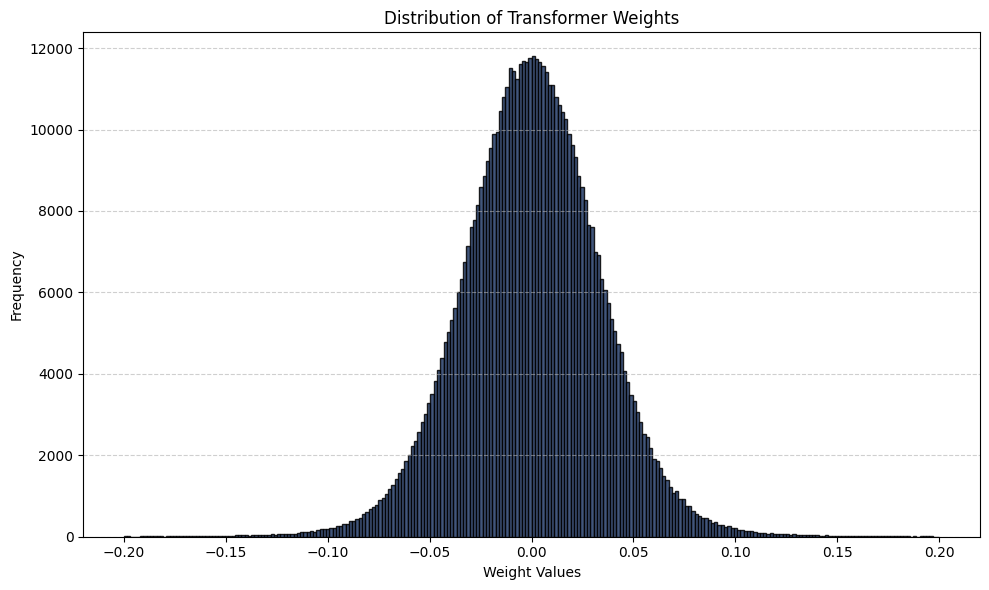

In [25]:
# Create the figure to show the distribution of the parameters
figsize = (10, 6)
color = '#203864'
flattened_weights = weights.flatten().numpy()

fig, ax = plt.subplots(figsize=figsize)
# Histogram plot
ax.hist(flattened_weights,
        bins=250,
		range=(-0.2, 0.2),
        color=color,
        edgecolor='black',
        alpha=0.85)

# Set labels and title
ax.set_xlabel("Weight Values")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Transformer Weights")

# style
ax.grid(axis="y",linestyle="--", alpha=0.6)
ax.get_figure().tight_layout()

In [26]:
# our model uses float32 types, which takes 4 bytes of memory per parameter
weights.dtype

torch.float32


### Linear Quantization

Our goal is to transform the model parameters, originally represented as `float32`, into `int8`, reducing memory from 4 bytes to 1 byte per parameter.   The `int8` format can store 256 possible values, ranging from -128 to 127.   More details on this process can be found in Chapter 10.


In [27]:
from torch import quantize_per_tensor
# torch as a function which performs this operation for us
dtype = torch.qint8
zero_point = 0
# divide the range of the weights over 255 (includes 0)
scale = (weights.max() - weights.min()) / (127 - (-128))
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)

quantized_weights.int_repr()

tensor([[ -5,  -8,   0,  ...,  -6,  -3,   8],
        [  8,   3,   1,  ...,  -4,   7,   1],
        [ -9,  -5,   5,  ...,   0,   5,  -3],
        ...,
        [  5,   0,  13,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -8, -13],
        [-13,  -1,  -9,  ...,   8,   2,  -2]], dtype=torch.int8)

### Quantized Weight Distribution

(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x7c735eed4c90>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x7c735f0e10d0>)

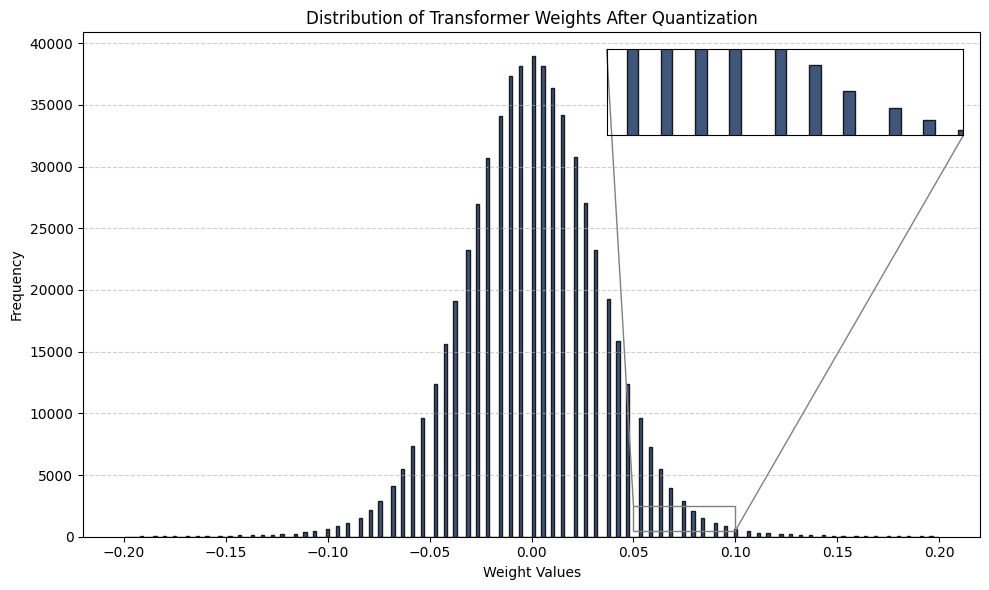

In [28]:
# Create the figure to show the distribution of quantized parameters
fig, ax = plt.subplots(figsize=figsize)
flattened_weights = quantized_weights.dequantize().flatten().numpy()

ax.hist(flattened_weights, bins=250,
        range=(-0.2, 0.2),
        color=color,
        edgecolor='black',
        alpha=0.85)

# Set labels and title
ax.set_xlabel("Weight Values")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Transformer Weights After Quantization")

# style
ax.grid(axis="y",linestyle="--", alpha=0.6)
ax.get_figure().tight_layout()

# Create zoom inset
axins = zoomed_inset_axes(ax, 3.5, loc='upper right', borderpad=1.2)
axins.hist(flattened_weights, bins=250, range=(-0.2, 0.2),
           color=color, edgecolor='black', alpha=0.85)

# Define zoomed-in region
x1, x2, y1, y2 = 0.05, 0.1, 500, 2500
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# Hide x/y labels on the inset for clarity
axins.set_xticks([])
axins.set_yticks([])

# Mark the zoomed-in section
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")


Let's verify how much faster `int8` matrix multiplication is compared to `float32`.

In [29]:
# Set the number of times to repeat the experiment
TIMES = 200

In [30]:
avg_float32_time = 0
for _ in range(200):
    start_time = time.time()
    weights @ weights
    elapsed_time = time.time() - start_time
    avg_float32_time += elapsed_time / TIMES

In [31]:
avg_float32_time

0.006753505468368536

In [32]:
from torch.nn.quantized import QFunctional
q_fn = QFunctional()
avg_int8_time = 0
for _ in range(200):
    start_time = time.time()
    q_fn.mul(quantized_weights, quantized_weights)
    elapsed_time = time.time() - start_time
    avg_int8_time += elapsed_time / TIMES

In [33]:
matmul_elap_time = pd.Series(
    [avg_float32_time, avg_int8_time, avg_float32_time / avg_int8_time],
    index=['float32', 'int8', 'speedupX'],
    name='time')
matmul_elap_time

,time
float32,0.006754
int8,0.000273
speedupX,24.767532


In [34]:
import sys
# 4x time compression!
sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())

<ipython-input-34-5794b963b91c>:3: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())


3.999715196311114

## Model Quantization

Now, let's use PyTorch to apply this transformation to all linear layers of our distilled model!

In [35]:
from torch.quantization import quantize_dynamic
quantized_model = quantize_dynamic(
    distil_model.to('cpu'),
    {nn.Linear},
    dtype=torch.qint8)

## Performance

Finally, it’s time to measure the performance and speed of our three models: the teacher (`FinBERT`), the distilled model, and the quantized model. We have implemented a `PerformanceBenchmark` class to help us measure both performance and inference speed.

Note that with the version of `PyTorch` used at the time the book was produced, quantized models can only be executed on CPU, so the benchmarks will be run on this device for a fair comparison.

Also, please note that your results might differ slightly from those reported in the book.  If you are running this on Colab, it's possible that the machine infrastructure, operating system, libraries, or other dependencies have been upgraded since the original experiments were done.



In [36]:
from dataclasses import dataclass
from typing import List, Dict, Union, Callable
import torch
from pathlib import Path
import tempfile
from transformers import pipeline
import time
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
from torch import nn
from tqdm.auto import tqdm

def compute_time_statistics(inference_times: np.ndarray, suffix: str) -> Dict[str, float]:
    inference_times = np.array(inference_times)
    return {f'avg_time{suffix}': inference_times.mean(), f'std_time{suffix}': inference_times.std()}


@dataclass
class PerformanceBenchmark:
    model_name: str
    model: nn.Module
    tokenizer: Callable[[str], Dict[str, torch.Tensor]]
    batch_size: int = 512
    sentence_realisations: int = 32
    batch_realisations: int = 32
    ds_realisations: int = 32

    def predict_single_batch(self, text_batch: List[str]) -> np.ndarray:
        inputs = self.tokenizer(text_batch, padding=True, truncation=True, return_tensors='pt').to(self.model.device)
        with torch.no_grad():
            output = self.model(**inputs)
            labels = torch.argmax(output.logits, dim=1).cpu().numpy()
        return labels

    def predict(self, texts: List[str]) -> np.ndarray:
        test_predictions = np.zeros(len(texts), dtype=np.int32)
        for i in tqdm(range(0, len(texts), self.batch_size)):
            batch = texts[i: i + self.batch_size]
            np_prediction = self.predict_single_batch(batch)
            test_predictions[i: i + self.batch_size] = np_prediction
        return test_predictions


    def compute_metrics(self, labels: np.ndarray, predictions: np.ndarray) -> Dict[str, float]:
        acc = accuracy_score(labels, predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
        scores = {
            "accuracy": acc,
            "precision": precision,
            "recall": recall,
            "f1": f1,
        }
        return scores

    def measure_per_sentence_inference_time(
        self,
        sentence: str,
        times: int = 10) -> Dict[str, float]:
        inference_times = []

        pipe = pipeline(
            'text-classification',
            model=self.model,
            tokenizer=self.tokenizer,
            device=self.model.device)

        for _ in range(times):
            start_time = time.time()
            _ = pipe(sentence)
            elapsed_time = time.time() - start_time
            inference_times.append(elapsed_time)
        return compute_time_statistics(inference_times, suffix='_per_sentence')

    def measure_per_batch_inference_time(
        self,
        batch: List[str],
        times: int = 10) -> Dict[str, float]:

        inference_times = []
        inputs = self.tokenizer(batch, padding=True, truncation=True, return_tensors='pt').to(self.model.device)

        for _ in range(times):
            start_time = time.time()
            with torch.no_grad():
                _ = self.model(**inputs)
            elapsed_time = time.time() - start_time
            inference_times.append(elapsed_time)
        return compute_time_statistics(inference_times, suffix='_per_batch')

    def measure_dataset_inference_time(
        self,
        texts: List[str],
        times: int = 10) -> Dict[str, float]:
        inference_times = []

        for _ in range(times):
            start_time = time.time()
            _ = self.predict(texts)
            elapsed_time = time.time() - start_time
            inference_times.append(elapsed_time)
        return compute_time_statistics(inference_times, suffix='_dataset')

    def compute_size(self) -> Dict[str, float]:
        with tempfile.NamedTemporaryFile() as tempf:
            state_dict = self.model.state_dict()
            torch.save(state_dict, tempf.name)
            # Calculate size in megabytes
            size_mb = Path(tempf.name).stat().st_size / (1024 * 1024)
            return {"size_mb": size_mb}

    def run(self, dataset) -> Dict[str, Union[float, int, str]]:
        predictions = self.predict(dataset['text'])
        metrics = self.compute_metrics(dataset['label'], predictions)
        longest_sentence = max(dataset['text'], key=lambda s: len(s))
        per_sentence_time = self.measure_per_sentence_inference_time(longest_sentence, times=self.sentence_realisations)
        size = self.compute_size()
        scores = {
            'model_name': self.model_name,
            **metrics,
            **per_sentence_time,
            **size
        }

        return scores

In [37]:
# Define dictionary of models to compare.
# Move models to CPU
CPU_MODELS_MAPPER = {
    'finBERT': teacher_model.to('cpu'),
    'distilFinBERT': distil_model.to('cpu'),
    'QuantizedDistilFinBERT': quantized_model,
}

In [38]:
_SCORES = []
for model_name, model in CPU_MODELS_MAPPER.items():
    print(model_name)
    benchmark_scores = PerformanceBenchmark(
      model_name=model_name,
      model=model,
      tokenizer=tokenizer,
      ds_realisations=16,
      batch_size=32).run(dataset['test'])
    _SCORES.append(benchmark_scores)

pd_cpu_scores = pd.DataFrame(_SCORES)

finBERT


  0%|          | 0/31 [00:00<?, ?it/s]

Device set to use cpu


distilFinBERT


  0%|          | 0/31 [00:00<?, ?it/s]

Device set to use cpu


QuantizedDistilFinBERT


  0%|          | 0/31 [00:00<?, ?it/s]

Device set to use cpu


In [39]:
pd_cpu_scores = pd.DataFrame(_SCORES)
pd_cpu_scores

,model_name,accuracy,precision,recall,f1,avg_time_per_sentence,std_time_per_sentence,size_mb
0,finBERT,0.839175,0.848629,0.839175,0.840662,0.175299,0.026900,417.726337
1,distilFinBERT,0.847423,0.849288,0.847423,0.847900,0.078843,0.004141,255.454607
2,QuantizedDistilFinBERT,0.835052,0.838847,0.835052,0.830458,0.059922,0.007392,132.289591
